In [26]:
import numpy as np
import os
from load_testdata import read_poly_coefficients, read_profile_pepsi, load_xyz, read_sasbdb
from debyecalc_Iq import DebyeCalculator
from collections import defaultdict
import glob
from scipy.interpolate import interp1d

%run formfactor_isabel.py
%run debyecalc_Iq.py
%run load_testdata.py

In [27]:
poly_coeffs = read_poly_coefficients('../poly_atomic.csv')

In [28]:
files = glob.glob('../../experimental_data/*.fit')
print(files)
for file in files:
    if file.endswith('.fit'):
        sasbdb_q, sasbdb_I, sasbdb_Imean, sasbdb_sigma = read_sasbdb(file)
        print(len(sasbdb_q), len(sasbdb_I), len(sasbdb_Imean))

['../../experimental_data/SASDAC2_fit1.fit', '../../experimental_data/SASDAH2_fit1.fit', '../../experimental_data/SASDAW3_fit1.fit', '../../experimental_data/SASDAJ6_fit1.fit', '../../experimental_data/SASDAQ2_fit1.fit']
1802 1802 1802
1722 1722 1722
2115 2115 2115
775 775 775
2091 2091 2091


In [34]:
out_files = glob.glob('pepsi-saxs_data/*.out')
log_files = glob.glob('pepsi-saxs_data/*.log')
print(out_files)
print(log_files)

for out_file, log_file in zip(out_files, log_files):
    Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi, pepsi_scaling = read_profile_pepsi(out_file, log_file)

['pepsi-saxs_data/SASDAW3_fit1_model1.out', 'pepsi-saxs_data/SASDAJ6_fit1_model1.out', 'pepsi-saxs_data/SASDAH2_fit1_model1.out', 'pepsi-saxs_data/SASDAC2_fit1_model1.out', 'pepsi-saxs_data/SASDAQ2_fit1_model1.out']
['pepsi-saxs_data/SASDAQ2_fit1_model1.log', 'pepsi-saxs_data/SASDAW3_fit1_model1.log', 'pepsi-saxs_data/SASDAJ6_fit1_model1.log', 'pepsi-saxs_data/SASDAH2_fit1_model1.log', 'pepsi-saxs_data/SASDAC2_fit1_model1.log']
Scaling: 5.59512e-09
Scaling: 6.28696e-10
Scaling: 2.67226e-10
Scaling: 2.71495e-09
Scaling: 3.34523e-09


In [35]:
pepsi_scaling

3.34523e-09

In [36]:
def fitting(Iexp, xyzfile, qvals, poly_coeffs, water_pos, error=None):
    debye = DebyeCalculator(q_min=np.min(qvals), q_max=np.max(qvals), num_q_points=len(qvals))
    qteo, Iteo = debye.calculate_Iq(xyzfile, poly_coeffs, water_pos)
    #Iteo = Iteo * scaling
    # chi-squared calculation
    if error is None:
        error = 0.001 * Iexp
    c = np.sum((Iexp*Iteo)/error**2) / np.sum((Iteo)**2/error**2)
    chi2 = 1/(len(qvals)-1) * np.sum(((Iexp - c*Iteo)/error) ** 2)
    return chi2

In [37]:
def fitting_pepsi(Iexp, qvals, Ipepsi, qpepsi, error=None):
    #error =0.01 *Iexp
    f = interp1d(qpepsi, Ipepsi, kind='linear', fill_value="extrapolate")
    Iteo = f(qvals)
    #scaling = np.mean(Iexp/Iteo)
    #Iteo = Iteo * scaling
    # chi-squared calculation
    if error is None:
        error = 0.001 * Iexp
    c = np.sum((Iexp*Iteo)/error**2)/np.sum(Iteo**2/error**2)
    chi2 = 1/(len(qvals)-1) * np.sum(((Iexp - c*Iteo)/error) ** 2)
    return chi2

In [38]:
def generate_hydration_shell(positions, cell_size=3.0, padding=12.0, min_dist=3.0, shell_width=3.0):
        """
        Generate a grid approximation of the hydration shell using the linked-cell approach.

        Parameters
        ----------
        positions : np.ndarray, shape (N,3)
            Atom positions.
        cell_size : float
            Grid spacing (Å).
        padding : float
            Extra padding beyond molecule bounding box (Å).
        min_dist : float
            Minimum distance from any atom (Å).
        shell_width : float
            Width of hydration shell (Å).

        Returns
        -------
        shell_cells : np.ndarray, shape (M,3)
            Centers of the cells approximating the hydration shell.
        """
        # 1. Bounding box with padding
        min_corner = np.min(positions, axis=0) - padding
        max_corner = np.max(positions, axis=0) + padding

        # 2. Create 3D grid of cell centers
        x = np.arange(np.floor(min_corner[0]), np.ceil(max_corner[0]) + cell_size, cell_size)
        y = np.arange(np.floor(min_corner[1]), np.ceil(max_corner[1]) + cell_size, cell_size)
        z = np.arange(np.floor(min_corner[2]), np.ceil(max_corner[2]) + cell_size, cell_size)
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        cell_centers = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

        # 3. Assign atoms to cells
        cell_indices = np.floor((positions - min_corner) / cell_size).astype(int)
        cells = defaultdict(list)
        for idx, (i, j, k) in enumerate(cell_indices):
            cells[(i, j, k)].append(idx)

        n_cells = (np.ceil((max_corner - min_corner) / cell_size)).astype(int)

        # Helper: get 26 neighbors + self
        def neighbor_cells(i, j, k):
            neighbors = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    for dk in [-1, 0, 1]:
                        ni, nj, nk = i + di, j + dj, k + dk
                        # ignore out-of-bounds
                        if 0 <= ni < n_cells[0] and 0 <= nj < n_cells[1] and 0 <= nk < n_cells[2]:
                            neighbors.append((ni, nj, nk))
            return neighbors

        # 4. Filter cells
        shell_cells = []
        for idx, center in enumerate(cell_centers):
            i = int(np.floor((center[0] - min_corner[0]) / cell_size))
            j = int(np.floor((center[1] - min_corner[1]) / cell_size))
            k = int(np.floor((center[2] - min_corner[2]) / cell_size))

            # Collect atoms in this cell + neighbors
            neighbor_atoms = []
            for ci, cj, ck in neighbor_cells(i, j, k):
                neighbor_atoms.extend(cells.get((ci, cj, ck), []))
            if not neighbor_atoms:
                continue  # skip empty regions

            # Compute distances
            dists = np.linalg.norm(positions[neighbor_atoms] - center, axis=1)
            # Apply criteria
            if np.all(dists > min_dist) and np.any(dists < (min_dist + shell_width)):
                shell_cells.append(center)

        return np.array(shell_cells)

SASDAC2 ../cg_structures/SASDAC2.xyz
Scaling: 3.34523e-09


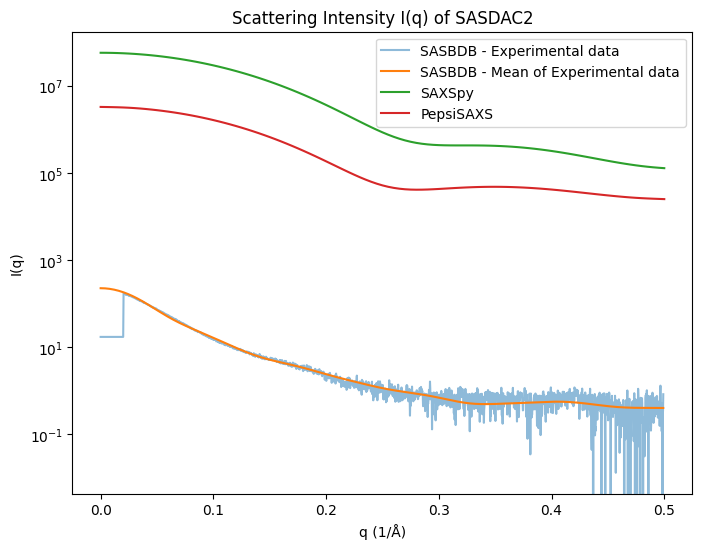

SASDAW3 ../cg_structures/SASDAW3.xyz
Scaling: 6.28696e-10


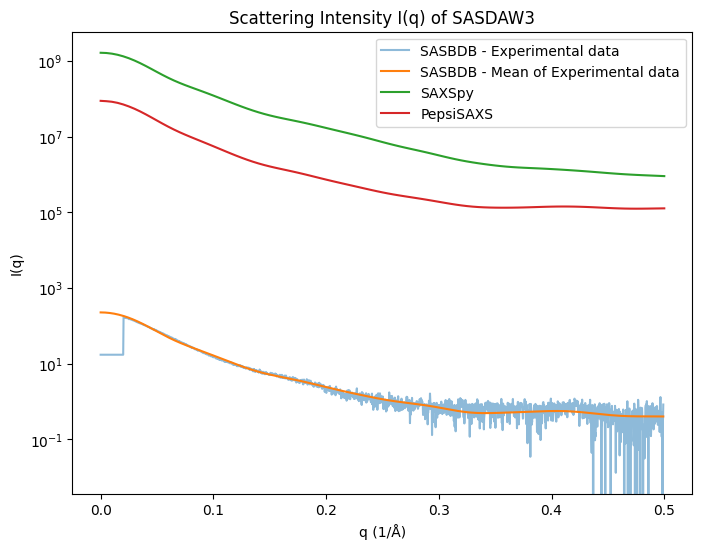

SASDAH2 ../cg_structures/SASDAH2.xyz
Scaling: 2.71495e-09


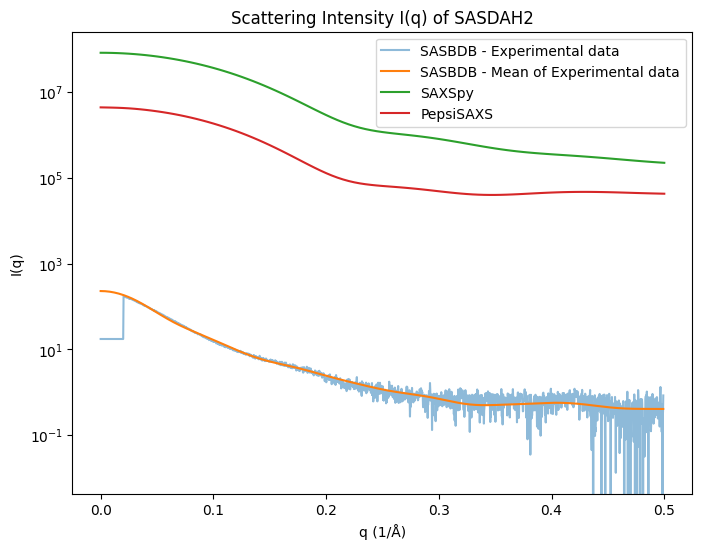

SASDAQ2 ../cg_structures/SASDAQ2.xyz
Scaling: 5.59512e-09


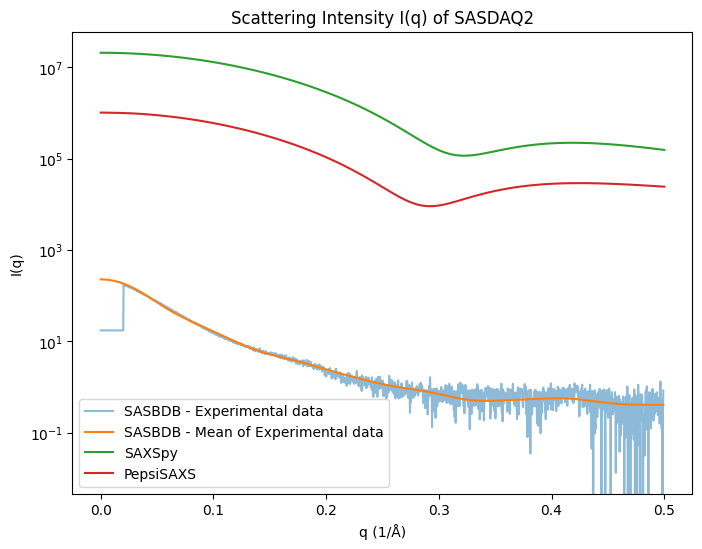

ala ../cg_structures/ala.xyz


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
xyz_files = glob.glob('../cg_structures/*.xyz') 
pepsi_path = 'pepsi-saxs_data/'
experimental_path = '../../experimental_data/'
debye = DebyeCalculator()
names = [os.path.splitext(os.path.basename(p))[0] for p in xyz_files]

for i, name in enumerate(names):
    print(name, xyz_files[i])
    amino_acids, coordinates = load_xyz(xyz_files[i])
    water_pos = generate_hydration_shell(coordinates, cell_size=5.0, padding=12.0, min_dist=5.0, shell_width=5.0)
    qvals, Iqvals = debye.calculate_Iq(xyz_files[i], poly_coeffs, water_pos)
    Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi, pepsi_scaling = read_profile_pepsi(f"{pepsi_path+name}_fit1_model1.out" , f"{pepsi_path+name}_fit1_model1.log")
    sasbdb_q, sasbdb_I, sasbdb_Imean, sasbdb_sigma = read_sasbdb(f"{experimental_path+name}_fit1.fit")
    #chi2 = fitting(sasbdb_Imean, xyz_files[i], sasbdb_q, poly_coeffs, water_pos, sasbdb_sigma)
    #chi2_pepsi = fitting_pepsi(sasbdb_Imean, sasbdb_q, Iq_tot, q_pepsi, sasbdb_sigma)
    f = interp1d(qvals, Iqvals, kind='linear', fill_value="extrapolate")
    f_qvals = f(sasbdb_q)
    #scaling = np.mean(f_qvals/Iq_tot[4:-2])
    scale = np.sum(sasbdb_I*f_qvals)/np.sum(f_qvals**2)
    debye.plot_Iq(qvals, Iqvals*scale, q_pepsi, Iq_tot*scale, sasbdb_q, sasbdb_I, sasbdb_Imean, name)
    #print(f"Chi-squared for {name}: {chi2}")
    #print(f"Chi-squared for PEPSI {name}: {chi2_pepsi}")
  

In [ ]:
amino_acids, coordinates = load_xyz(xyz_files[0])
water_pos = generate_hydration_shell(coordinates, cell_size=5.0, padding=12.0, min_dist=5.0, shell_width=5.0)
qvals, Iqvals = debye.calculate_Iq(xyz_files[0], poly_coeffs, water_pos)
Iq_tot, Iat, Iev, Ihs, atev, aths, evhs, q_pepsi, pepsi_scaling = read_profile_pepsi(f"{pepsi_path+name}_fit1_model1.out" , f"{pepsi_path+name}_fit1_model1.log")

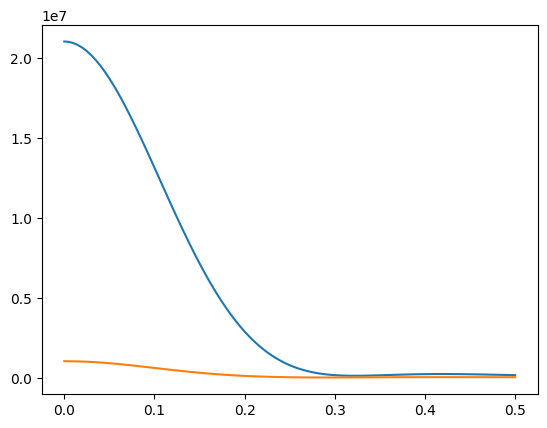

In [44]:
plt.plot(qvals, Iqvals)
plt.plot(q_pepsi, Iq_tot)